### `Проблема быстродействия python`
Главным недостатком языка python принято считать его скорость. Разгонять python с переменным успехом стали чуть ли не с первых дней его существования: shedskin, psyco, unladen shallow, parakeet, theano, nuitka, pythran, cython, pypy, numba.

__Наиболее востребованные инструменты ускорения работы языка:__
- Cython (не путать с cpython). 
- pypy
- numba

__Cython__:
- довольно сильно отличается семантически от обычного python
- некий гибрид c и python 

__Pypy__:
- альтернативная реализация транслятора python с использованием jit-компиляции
- поддержка всех конструкций python

__Numba__:
- библиотека для транскомпиляции кода в llvm
- переводит подмножество кода Python и NumPy в быстрый машинный код
- постепенно увеличивается «охват» (например, до недавнего времени не было поддержки строк, сейчас она появилась)

__Почему именно Numba?__:
-  В numba разгоняется не вся программа, а отдельные функции, это позволяет совместить высокую скорость и обратную совместимость с библиотеками, которые numba (пока) не поддерживает.
- Numba обгоняет cython за счёт использования нативных процессорных инструкций (cython не умеет jit), а pypy – за счёт более эффективного выполнения байткода llvm.

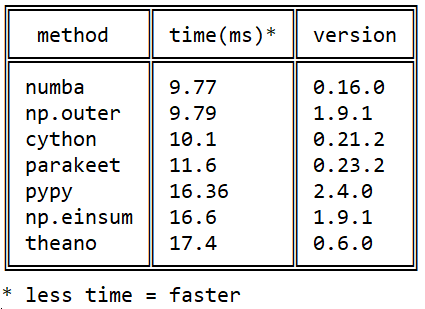

__Полезные ссылки__:
- https://numba.pydata.org/
- https://github.com/numba/numba
- https://habr.com/ru/post/484136/

### `Введение в numba`

#### `Как установить?`
- pip install numba (при использовании pip)
- conda install numba (при использовании conda)

#### `Как использовать?`

__Для ускорения функции, необходимо поместить перед ней декоратор__:
- `@jit` -  в этом режиме можно использовать неподдерживаемые нумбой операции: нумба на большой скорости доходит до первой такой операции, затем замедляется, и до конца функции исполнение продолжается с обычной питоновской скоростью, даже если больше в функции ничего «запретного» не встречается (т.н. object mode), что, очевидно, нерационально.
- `@njit`(или `@jit(nopython=True)`) - в этом режиме нумба ругается исключениями на такие места – всё равно лучше их переписать, чтобы не потерять в скорости.

### `Сравнение numba и обычного кода`:

In [5]:
def timed(method):
    import time
    def __timed(*args, **kw):
        time_start = time.time()
        result = method(*args, **kw)
        time_end = time.time()
        
        print('{}  {:.3f} ms\n'.format(method.__name__,
                                      (time_end - time_start) * 1000))
        return result

    return __timed

In [16]:
from numba import jit
import random

@timed
def monte_carlo_pi_without_numba(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

@timed
@jit(nopython=True)
def monte_carlo_pi_using_numba(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

monte_carlo_pi_without_numba(100000)
monte_carlo_pi_using_numba(100000)

monte_carlo_pi_without_numba  73.997 ms

monte_carlo_pi_using_numba  1005.993 ms



3.15112

__Почему в данном случае код с numba работал дольше?__:
- перед запуском метода в первый раз происходит его компиляция
- также компиляция происходит при первом запуске метода с параметрами другого типа

__Как этого избегать? Три варианта:__
- "Прогревать кэш" - перед использовнием метода прогнать его вхолостую, то есть передать в метод наименьший возможный объем данных
- Указывать аргумент @jit(cache=True) для сохранения скомпилированного кода на диск с автоматической его загрузкой при последующих запусках программы
- Явно задать сигнатуру метода (этот последний способ не future-safe. Авторы numba предупреждают о том, что синтаксис указания типов может измениться в будущем, @jit/@njit без сигнатур – более безопасный в этом плане вариант).

In [17]:
@timed
@jit(cache=True, nopython=True)
def monte_carlo_pi_using_numba_with_cache(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

monte_carlo_pi_without_numba(100000)
monte_carlo_pi_using_numba_with_cache(100000)

monte_carlo_pi_without_numba  65.999 ms

monte_carlo_pi_using_numba_with_cache  170.003 ms



3.13752

In [22]:
from numba import njit

@timed
@njit("double(int32)")
def monte_carlo_pi_using_numba_with_signature(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [19]:
monte_carlo_pi_without_numba(100000)
monte_carlo_pi_using_numba(100000)
monte_carlo_pi_using_numba_with_signature(100000)
monte_carlo_pi_using_numba_with_cache(100000)

monte_carlo_pi_without_numba  142.522 ms

monte_carlo_pi_using_numba  2.000 ms

monte_carlo_pi_using_numba_with_signature  1.999 ms

monte_carlo_pi_using_numba_with_cache  1.999 ms



3.14252

Как можно заметить, каждый способ дает выигрыш в несколько десятков раз по сравнению с обычным python.

### `Параллельность в numba:`
С декоратором @njit(parallel=True) нумба анализирует код разгоняемой функции, находит такие участки, каждый из которых самого по себе распараллелить невозможно, и выполняет их одновременно на разных ядрах CPU(https://numba.pydata.org/numba-doc/dev/user/parallel.html).
